# FSDS24 - Week 1, Lab1: Exploring distributions

This lab continues where the walkthrough left off. We now have data which we can load from the Movies stack exchange. We can view that data, filter it and report on it. 

Below are a series of exercises that we will cover in the lab on Monday, October 14, 2024 and review with example answers on October 16, 2024. These exercises will not be graded, but will be part of a warm up to the exercises on Friday which will be given feedback by the TAs and/or the course convenor.

Today's tasks will be about the exploration of this data. It should be a simple exercise to view this work with ample starter code for you to get running. 

You are welcome to both modify this code and to share some example code and visualisations with your peers. 

> Note on data access: The exercise on Friday initially assumed access to the Internet Archive. However, on account of the recent hack of this site, the web portal for downloading Stack Exchange data is currently down. The exercise for Friday is currently being modified to adapt to this.

# Exercise 1. Load the movies data, and report on key variables

The Movies data exists in two tables in a folder on Canvas. These are to be downloaded and placed in a folder where you will be able to load and review the data. Where you see `...` you are to complete the code. 

## E1. Your code

In [1]:
import pandas as pd 

stack_df = pd.read_feather("data/movies_stack_df.feather")

print(stack_df.info())
print("The variables in this data set are:\n", "\n".join(stack_df.columns))

print()

# Describe the following:
# - How many rows are in this data set
print(f"Data set has {len(stack_df)} rows.")

# - How many columns
print(f"Data set has {len(stack_df.columns)} columns.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64054 entries, 0 to 64053
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     64054 non-null  object        
 1   PostTypeId             64054 non-null  object        
 2   AcceptedAnswerId       13634 non-null  object        
 3   CreationDate           64054 non-null  datetime64[ns]
 4   Score                  64054 non-null  int64         
 5   ViewCount              22570 non-null  float64       
 6   Body                   64054 non-null  object        
 7   OwnerUserId            62148 non-null  object        
 8   LastEditorUserId       40154 non-null  object        
 9   LastEditDate           40848 non-null  datetime64[ns]
 10  LastActivityDate       64054 non-null  datetime64[ns]
 11  Title                  22570 non-null  object        
 12  Tags                   22570 non-null  object        
 13  A

# Exercise 2. Exploring distributions 

Have a look at the Data Wrangler for the Movies data. Notice the numeric columns. Interrogate one of these columns to determine if it looks like a uniform, normal or scale free distribution. 

- Plot the column of data on a linear and a log-log axis 
- Report the Kolmogorov-Smirnov test for all three distribution types. 
- Report the skewness score.
- **Advanced**: Plot the QQ plot against the distribution function that best matches the observed distribution. 


## E2. Your code 

I'm going to investigate "Comment Count", which I expect to be power-law distributed as Bernie suggested in the video walkthrough.

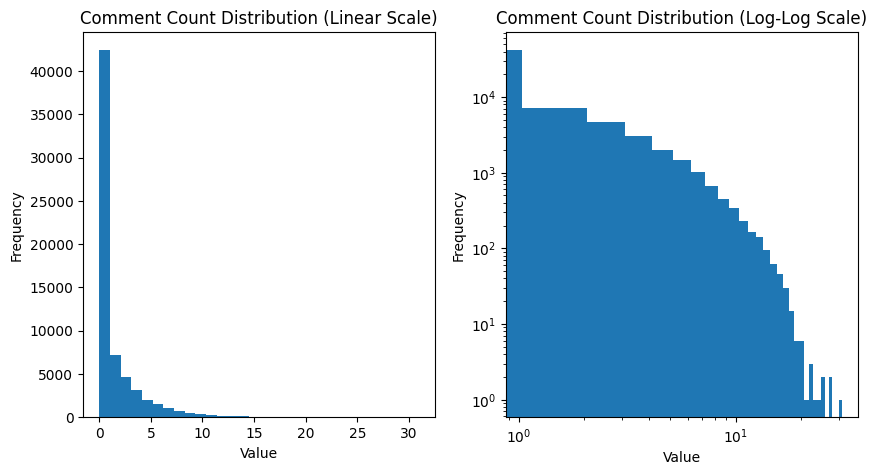

In [124]:
import matplotlib.pyplot as plt

# Process data
series_data = stack_df['CommentCount']

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Linear plot
ax1.hist(series_data, bins=30)
ax1.set_title('Comment Count Distribution (Linear Scale)')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

# Log-log plot
ax2.hist(series_data, bins=30)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Comment Count Distribution (Log-Log Scale)')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.show()

Ok, not a perfect linear relationship on the log-log, chart, but let's check goodness-of-fit for various distributions.

One thing I want to check is if *any* KS test returns a nonzero p-value, given the sample size or diversity might not be sufficient for a meaningful result. So let's exhaustively check each numeric column:

In [117]:
from scipy import stats

for colname in stack_df.columns:
    # We'll test only the numeric columns
    try:
        series_data = pd.to_numeric(stack_df[colname])
    except:
        print(f"Column {colname} counldn't be cast numerically; continuing.")
        continue

    # Drop missing or NaN values that the test will not tolerate
    series_data = series_data.dropna()

    # Now check each distribution -- I include three scale-free distributions: power law, exponential, and Pareto
    for dist in ["uniform", "norm", "pareto", "powerlaw", "expon", "lognorm"]:
        # Use an alpha of 2.5 for powerlaw, matching the video walkthrough
        _, p_value = stats.kstest(series_data, dist, args=[2.5])
        if p_value > 0:
            print(f"Eureka! Column {colname} fits distribution {dist} with p-value {p_value} in the KS test.")

Column Body counldn't be cast numerically; continuing.
Column Title counldn't be cast numerically; continuing.
Column Tags counldn't be cast numerically; continuing.
Column ContentLicense counldn't be cast numerically; continuing.
Column LastEditorDisplayName counldn't be cast numerically; continuing.
Column OwnerDisplayName counldn't be cast numerically; continuing.
Column BodyText counldn't be cast numerically; continuing.
Column BodyURLs counldn't be cast numerically; continuing.
Column TagsList counldn't be cast numerically; continuing.


Ok rad, nothing. Let's compare the KS scores anyway and also look at skewness.

In [118]:
series_data = stack_df['CommentCount']

ks_statistic, p_value = stats.kstest(series_data, 'uniform')

print("Uniform Distribution")
print(f"  KS Statistic: {ks_statistic}")
print(f"  p-value: {p_value}")

ks_statistic, p_value = stats.kstest(series_data, 'norm')

print("Normal Distribution")
print(f"  KS Statistic: {ks_statistic}")
print(f"  p-value: {p_value}")

ks_statistic, p_value = stats.kstest(series_data, 'expon', args=[2.5])

print("Scale-Free (Exponential) Distribution")
print(f"  KS Statistic: {ks_statistic}")
print(f"  p-value: {p_value}")

print()

print(f"Skewness (CommentCount): {series_data.skew()}")

Uniform Distribution
  KS Statistic: 0.5103974771286727
  p-value: 0.0
Normal Distribution
  KS Statistic: 0.5
  p-value: 0.0
Scale-Free (Exponential) Distribution
  KS Statistic: 0.7738939020201705
  p-value: 0.0

Skewness (CommentCount): 2.47450412838415


Comments are heavily positive / right skewed. This is easy to see in the linear scale histogram.

Finally, let's show a Q-Q plot with the powerlaw and log normal distributions.

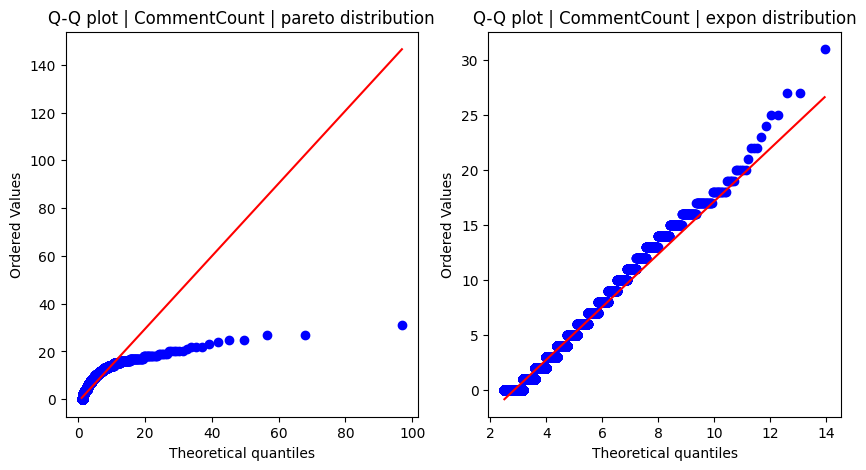

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for i, dist in enumerate(["pareto", "expon"]):
    stats.probplot(series_data, dist=dist, plot=axes[i], sparams=[2.5])
    axes[i].set_title(f"Q-Q plot | CommentCount | {dist} distribution")

plt.show()

The exponential fit seems to be best, although the top of the distribution seems to exhibit "super-exponential" behavior (maybe "front page" posts with lots of comments).

# Exercise 3. Comparing questions to answers 

In the walkthrough it was shown that there were both questions and answers in this data. Take one of the numeric columns that would apply to both questions and answers. Are the distributions similar? First plot them side-by-side, and then do a `kstest` but this time to compare one distribution to the other.  So in this case, if the questions were stored in a series called `question_score` and the answers in a series called `answer_score`, the test would be: 

~~~ 
ks_statistic, p_value = stats.ks_2samp(question_score, answer_score)
~~~

Print the mean, median, mode, max, and min for each distribution. Then print the results of the `kstest`. Speculate on the reason why you observed these results. What might this say about the difference between behaviour related to questions and behaviour related to answers?   

## E3. Your code
The "score" of the question is probably best characterized by `Score` in the dataset. For answers, we should look at `AnswerCount`. Intuitively we should expect that `Score` and `AnswerCount` are correlated.

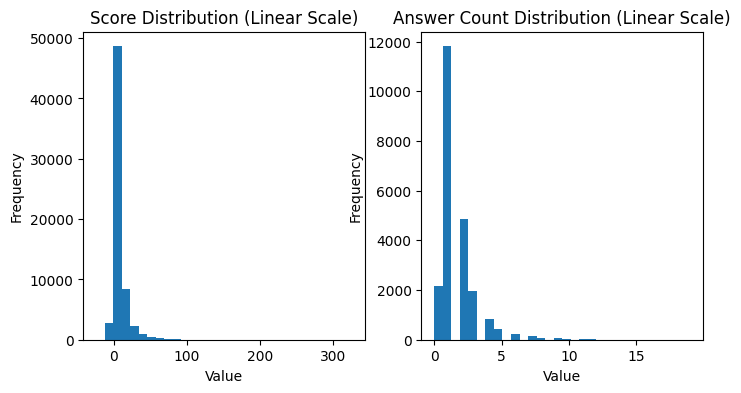

In [129]:
# Drop missing and NaN values from the columns
question_score = stack_df['Score'].dropna()
answer_score = stack_df['AnswerCount'].dropna()

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Linear plot
ax1.hist(question_score, bins=30)
ax1.set_title('Score Distribution (Linear Scale)')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

# Log-log plot
ax2.hist(answer_score, bins=30)
ax2.set_title('Answer Count Distribution (Linear Scale)')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.show()

In [131]:
question_score.describe()

count    64054.000000
mean         7.262966
std         11.699989
min        -24.000000
25%          1.000000
50%          4.000000
75%          9.000000
max        326.000000
Name: Score, dtype: float64

In [132]:
answer_score.describe()

count    22570.000000
mean         1.640939
std          1.445729
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: AnswerCount, dtype: float64

In [130]:
ks_statistic, p_value = stats.ks_2samp(question_score, answer_score)

print(f"KS Statistic: {ks_statistic}")
print(f"p-value: {p_value}")

KS Statistic: 0.4667043670051378
p-value: 0.0


While on first glance, the distributions look similar, we cannot expect they come from the same underlying distribution or even different scales of the same distribution. Notice that score can be negative, while answer count at minimum can be zero. Both distributions are heavily right skewed, and have something that looks like a scale-free decay, but mathematically they are likely to come from different distributions.

# Exercise 4. Tabulating univariate categorical data

While categorical data can be plot as a distribution, it would mainly be the frequency of the unique categories as a bar chart or a pie chart. To that end, it is often just as useful to tabulate the data instead. The simplest way to do this in pandas is to use the `value_counts()` method, which creates a new Series with the index being the categories and the counts of their frequency being the rows of the Series. 

Below, practice tabulating categorical data by finding a way to table the top categories of a distribution but truncating the table. You can truncate the table by omitting the categories with small N, but it would be more preferable to create a new category called 'other' which will include a count of the remaining data.

In [2]:
## STARTER CODE
def tabulate_categorical_basic(series: pd.Series):
    return series.value_counts().reset_index()

tabulate_categorical_basic(EXAMPLE_DATA["sex"])

NameError: name 'EXAMPLE_DATA' is not defined

## YOUR CODE BELOW

In [140]:
def tabulate_categorical_basic(series: pd.Series) -> pd.Series:
    # Get the counts of each category
    value_counts = series.value_counts()
    
    # Identify the top 5 most common values
    top_5 = value_counts.nlargest(5)
    
    # Aggregate all other values as "other"
    other_count = value_counts.iloc[5:].sum()
    
    # Create a new series that includes the top 5 and "other"
    top_5['other'] = other_count
    
    # Reset index to return a DataFrame
    return top_5.reset_index()

To try this function, let's use the first tag of each post. There are 11693 distinct sets of tags in the dataset, in the `Tags` column, but fewer if we just consider the first value:

In [148]:
print(f"Unique sets of tags: {len(stack_df['Tags'].dropna().unique())}")

# Tags are formatted like <tag> and separated without spaces, like <tag1><tag2>, so split on '><' occurrences
print(f"Unique first tags: {len(stack_df['Tags'].dropna().map(lambda x: x.split('><')[0] + '>').unique())}")

Unique sets of tags: 11693
Unique first tags: 1800


In [149]:
tabulate_categorical_basic(stack_df["Tags"].dropna().map(lambda x: x.split("><")[0] + ">"))

,Tags,count
0,<plot-explanation>,8181
1,<character>,1759
2,<analysis>,997
3,<dialogue>,620
4,<marvel-cinematic-universe>,541
5,other,10472


# AI Declaration 

Below we would like you to draft a few sentences indicating how AI code tools were used in this assignment. You can review the declaration in the virtual walkthrough for reference. 

> YOUR DECLARATION HERE

# Appendix: Some starter code for plotting

In addition to the code in the virtual walkthrough, below is also some code that can be used. Notice that this code uses several Python conventions that we would recommend but are not strictly necessary: 
- **Type hinting**: This is where the arguments also specify their type, so instead of `def new_function(var):` one would write `def new_function(var: str)` to signal that it should take a string variable. Similarly writing `def new_function(var) -> str:` would signal that the function should return a string value. These are not rules for Python, but signals for a debugger. 
- **PyDoc**. Notice the `"""` just below the function names. This first line under the function is used to describe the name of the function. There are many variations in how this is written. Generally be succinct in here, but there are conventions for more involved comments in functions. To get a sense of these, simply start reading others' source code as well as refer to PEP-8, which is the Python recommendation for coding style. 
- **Robustness checks**: Notice that that `single_continuous_plot` uses "Duck typing" to check for a label and if not present creates one from the variable name.

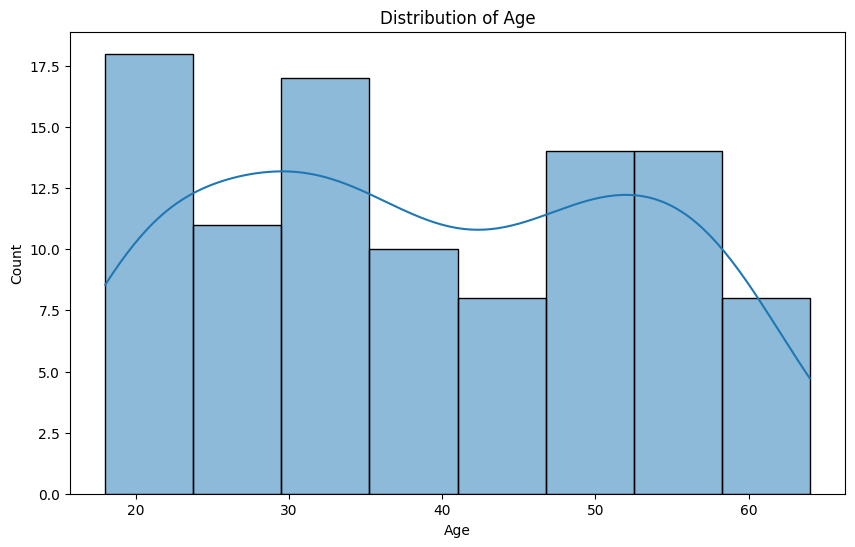

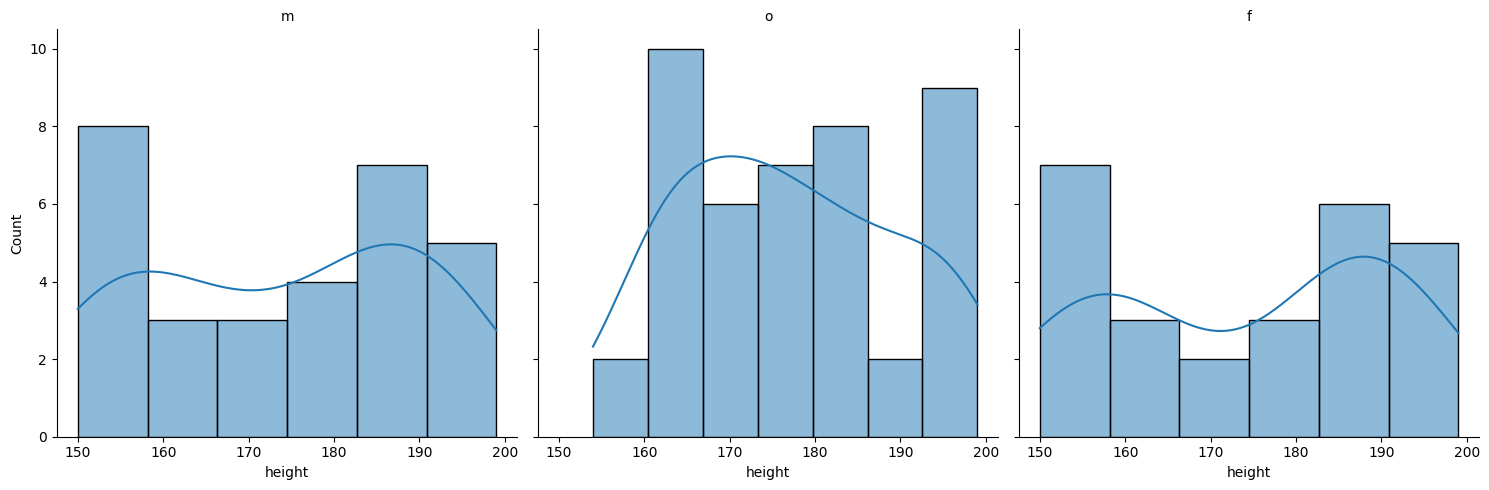

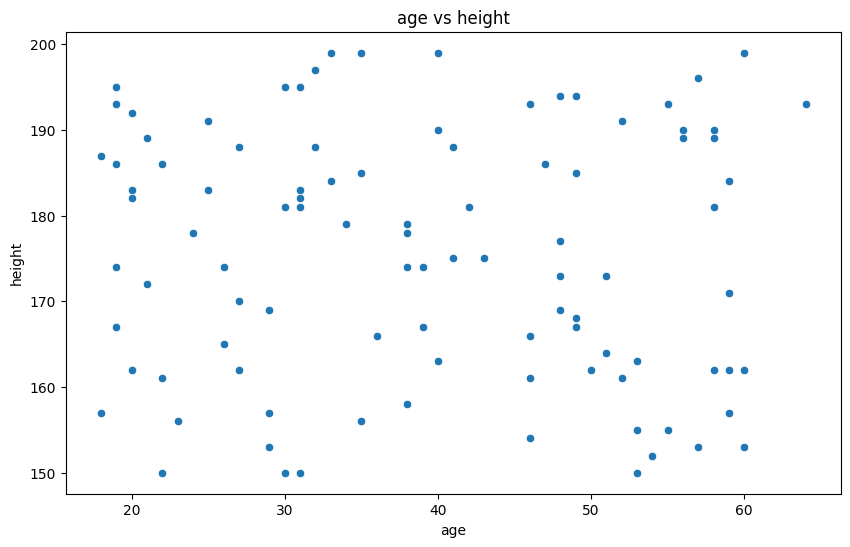

In [3]:
# Starter code 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def single_continuous_plot(series: pd.Series, xlabel: str | None = None) -> None:
    """
    Plots a histogram of a single continuous variable.
    """
    if xlabel is None:
        xlabel = series.name.capitalize()
    plt.figure(figsize=(10, 6))
    # Note: The below function has a lot of optional arguments, which you can check out:
    # https://seaborn.pydata.org/generated/seaborn.histplot.html
    sns.histplot(data=series, kde=True)
    plt.title(f"Distribution of {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.show()


def facet_continuous_plot(df: pd.DataFrame, colname: str, facet: str) -> None:
    """
    Facets a continous variables (`colname`) by a categorical variable (`facet`).
    """

    g = sns.FacetGrid(df, col=facet, col_wrap=3, height=5)
    g.map(sns.histplot, colname, kde=True)
    g.set_axis_labels(colname, "Count")
    g.set_titles("{col_name}")
    plt.tight_layout()
    plt.show()


def two_continuous_plot(df: pd.DataFrame, colname1: str, colname2: str) -> None:
    """
    Plots two continous variables against each other in a scatter plot.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=colname1, y=colname2)
    plt.title(f'{colname1} vs {colname2}')
    plt.xlabel(colname1)
    plt.ylabel(colname2)
    plt.show()

# Example data for showing the plots
EXAMPLE_DATA = pd.DataFrame(
    {
        "age": np.random.randint(18, 65, 100),
        "sex": np.random.choice(["m", "f", "o"], 100),
        "height": np.random.randint(150, 200, 100),
    }
)

# Plot all three plots in a column
single_continuous_plot(EXAMPLE_DATA["age"])
facet_continuous_plot(EXAMPLE_DATA, colname="height", facet="sex")
two_continuous_plot(EXAMPLE_DATA, colname1="age", colname2="height")

